In [77]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import pandas as pd 
import numpy as np 
import datetime as dt
import pickle 
import cv2
from IPython.display import Image
import multiprocessing as mp
import shutil
from platform import python_version
import psutil
import os
import datetime
import collections

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras. preprocessing import *
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorboard import notebook
from tensorflow.data.experimental import AUTOTUNE

In [78]:
TEST_DIR = "/home/jupyter/data/frames_split/test"
TRAIN_DIR = "/home/jupyter/data/frames_split/train"
VALIDATION_DIR = "/home/jupyter/data/frames_split/val"

MODEL_DIR = "/home/jupyter/model"
TENSORBOARD_DIR = "/home/jupyter/tensorboard"
OUTPUT_DIR = "/home/jupyter/output"
CHECKPOINT_DIR = "/home/jupyter/output/checkpoint"

In [79]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("Python version: ", python_version())
print("Tensorflow version: ", tf.__version__)
print("Keras version: ", tf.keras.__version__)
mem = psutil.virtual_memory()
print("Total RAM (GB): ", mem.total/1024/1024)
cpu = mp.cpu_count()
print("CPU Cores: ", cpu)
%system nvidia-smi

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17143727138256143991
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12899270429611857911
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10066296332159792259
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11133970048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3524152396149768866
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
Python version:  3.7.6
Tensorflow version:  2.3.0
Keras version:  2.4.0
Total RAM (GB):  30163.0
CPU Cores:  8


['Tue Sep  8 06:15:15 2020       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   54C    P0    59W / 149W |  10871MiB / 11441MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '                                                                               ',
 '+-----------------------------------------------------------------------------+',
 '| Processes:                          

In [80]:
EPOCHS = 10
BATCH_SIZE = 32
TARGETX = 224
TARGETY = 224
LEARNING_RATE = 0.0001
CLASSES = 3
SEED = 42
SIZE = (TARGETX,TARGETY)
INPUT_SHAPE = (TARGETX, TARGETY, 3)
CHANNELS = 3
NBFRAME = 32
INSHAPE = (None, TARGETX, TARGETY, 3)

In [81]:
test_img_0 = "/home/jupyter/data/frames_split/test/0"
test_img_5 = "/home/jupyter/data/frames_split/test/5"
test_img_10 = "/home/jupyter/data//frames_split/test/10"

In [82]:
IMG_0 = [files for root, directories, files in os.walk(test_img_0, topdown=False)]
IMG_5 = [files for root, directories, files in os.walk(test_img_5, topdown=False)]
IMG_10 = [files for root, directories, files in os.walk(test_img_10, topdown=False)]

In [83]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

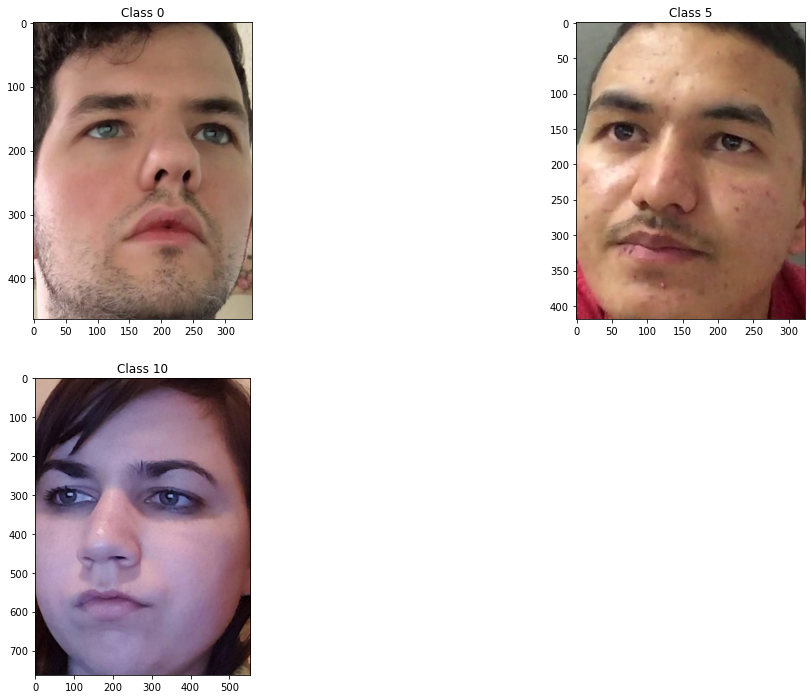

In [84]:
# Plot image from each of the classes 

img1 = mpimg.imread(os.path.join(test_img_0, IMG_0[0][1000]))
img2 = mpimg.imread(os.path.join(test_img_5, IMG_5[0][1000]))
img3 = mpimg.imread(os.path.join(test_img_10, IMG_10[0][1000]))

show_images([img1, img2, img3], cols = 2, titles=["Class 0", "Class 5", "Class 10"])

In [85]:
# Rescale the pixel values 

# Model expects the input to be in the range of [-1. 1]

# Currenlty the pixels are in the range of 0 - 255

# preprocess_input_ = preprocess_input # from mobilenet 

In [86]:
train_dataset = image_dataset_from_directory(
    directory=TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=["0", "10", "5"],
    image_size=SIZE,
    seed=SEED,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

Found 519311 files belonging to 3 classes.


In [87]:
validation_dataset = image_dataset_from_directory(
    directory=VALIDATION_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=["0", "10", "5"],
    image_size=SIZE,
    seed=SEED,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

Found 28830 files belonging to 3 classes.


In [88]:
test_dataset = image_dataset_from_directory(
    directory=TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=["0", "10", "5"],
    image_size=SIZE,
    seed=SEED,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

Found 28829 files belonging to 3 classes.


In [89]:
train_dataset.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))

In [90]:
baseModel = MobileNetV2(include_top=False,
         input_shape=INPUT_SHAPE,
         weights='imagenet')

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dense(3, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

In [91]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [92]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(multi_label=False,name='auc'),
      CategoricalAccuracy(name="categorical_acc")
]

log_dir = "/home/jupyter/logs/fit_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# class haltCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('val_loss') <= 0.05):
#             print("\n\n\nReached 0.05 validation loss value so cancelling training!\n\n\n")
#             self.model.stop_training = True
            
# val_loss_stop = haltCallback()


In [93]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
              loss="categorical_crossentropy",
              metrics=METRICS)

In [94]:
CALLBACKS = [
    ModelCheckpoint(
        '/home/jupyter/checkpoint/best_model4_{epoch}.h5',
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        mode="min"),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-2, 
        mode='min', 
        verbose=1, 
        patience=2
        ),
    TensorBoard(log_dir=log_dir, histogram_freq=1),
]

In [95]:
history = model.fit(train_dataset,
                    epochs = EPOCHS,
                    verbose=1, 
                    batch_size= BATCH_SIZE, 
                    callbacks= CALLBACKS, 
                    validation_data=validation_dataset,
                   )

Epoch 1/10
16229/16229 [==============================] - 2675s 165ms/step - loss: 0.0962 - tp: 499453.0000 - fp: 8860.0000 - tn: 1029762.0000 - fn: 19858.0000 - accuracy: 0.9816 - precision: 0.9826 - recall: 0.9618 - auc: 0.9983 - categorical_acc: 0.9727 - val_loss: 0.0181 - val_tp: 28686.0000 - val_fp: 124.0000 - val_tn: 57536.0000 - val_fn: 144.0000 - val_accuracy: 0.9969 - val_precision: 0.9957 - val_recall: 0.9950 - val_auc: 0.9998 - val_categorical_acc: 0.9953
Epoch 2/10
16229/16229 [==============================] - 2675s 165ms/step - loss: 0.0127 - tp: 517532.0000 - fp: 1573.0000 - tn: 1037049.0000 - fn: 1779.0000 - accuracy: 0.9979 - precision: 0.9970 - recall: 0.9966 - auc: 0.9999 - categorical_acc: 0.9968 - val_loss: 0.0118 - val_tp: 28732.0000 - val_fp: 87.0000 - val_tn: 57573.0000 - val_fn: 98.0000 - val_accuracy: 0.9979 - val_precision: 0.9970 - val_recall: 0.9966 - val_auc: 0.9999 - val_categorical_acc: 0.9968
Epoch 3/10
16229/16229 [==============================] - 257

In [108]:
def plot_(history):
    auc = history.history['auc']
    val_auc = history.history['val_auc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    
    cat_acc = history.history['categorical_acc']
    cat_acc_val = history.history['val_categorical_acc']
    
    plt.figure(figsize=(10,30))
    plt.subplot(5, 1, 1)
    plt.plot(auc, label='Training AUC')
    plt.plot(val_auc, label='Validation AUC')
    plt.legend(loc='best')
    plt.ylabel('AUC')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation AUC')
    plt.xlabel('epoch')

    plt.subplot(5, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.ylabel('Loss')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    
    plt.subplot(5, 1, 3)
    plt.plot(precision, label='Training Precison')
    plt.plot(val_precision, label='Validation Precision')
    plt.legend(loc='best')
    plt.ylabel('Loss')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Precision')
    plt.xlabel('epoch')
    
    plt.subplot(5, 1, 4)
    plt.plot(recall, label='Training Recall')
    plt.plot(val_recall, label='Validation Recall')
    plt.legend(loc='best')
    plt.ylabel('Loss')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Recall')
    plt.xlabel('epoch')
    
    plt.subplot(5, 1, 5)
    plt.plot(cat_acc, label='Training Categorical Accuracy')
    plt.plot(cat_acc_val, label='Validation Categorical Accuracy')
    plt.legend(loc='best')
    plt.ylabel('Categorical Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Categorical Accuracy')
    plt.xlabel('epoch')
    plt.savefig('/home/jupyter/output/results4.pdf')
    plt.show()

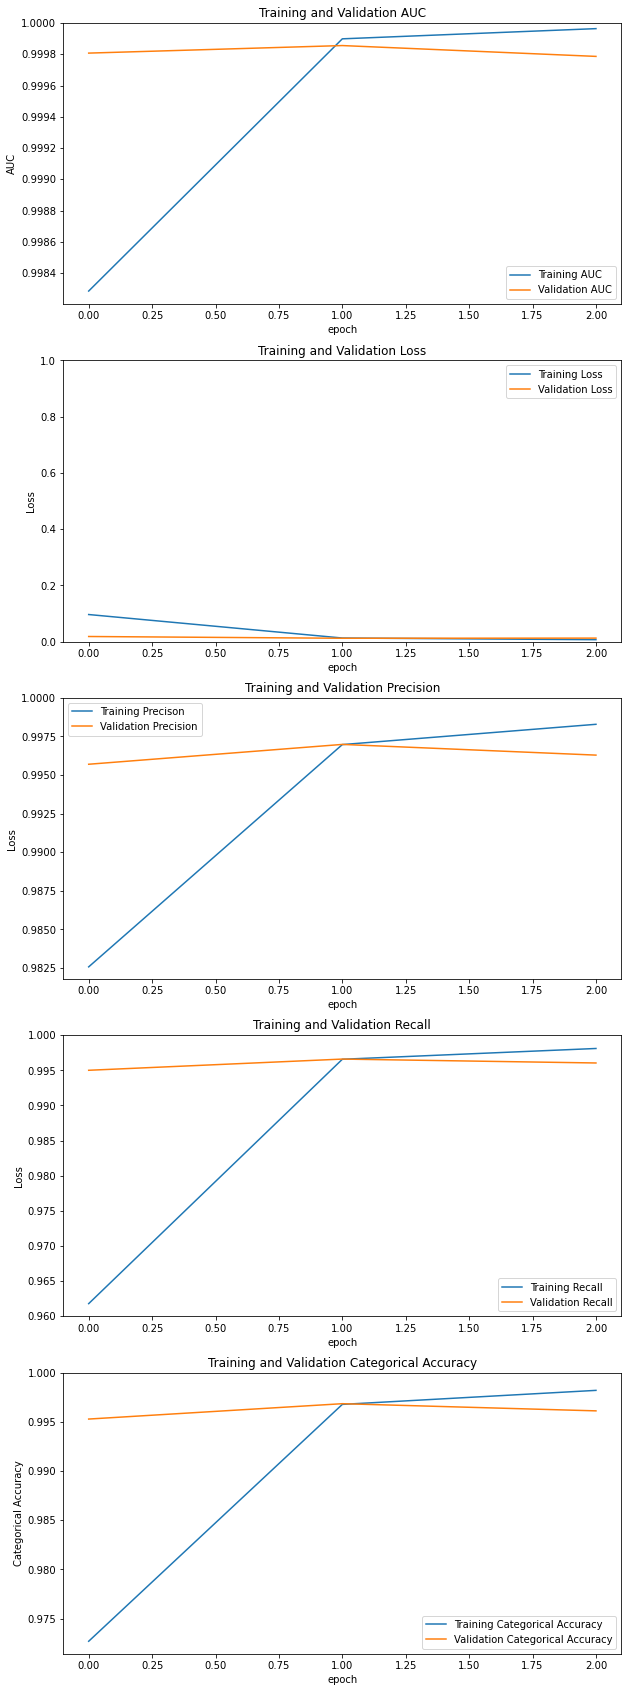

In [109]:
plot_(history)

In [98]:
# Model 1
model.load_weights(filepath="/home/jupyter/checkpoint/best_model4_1.h5")
# model.load_weights(filepath="/home/jupyter/checkpoint/best_model_2.h5")

In [99]:
model.evaluate(test_dataset, batch_size=BATCH_SIZE,verbose=2)

901/901 - 140s - loss: 0.0186 - tp: 28700.0000 - fp: 117.0000 - tn: 57541.0000 - fn: 129.0000 - accuracy: 0.9972 - precision: 0.9959 - recall: 0.9955 - auc: 0.9998 - categorical_acc: 0.9957


[0.018574688583612442,
 28700.0,
 117.0,
 57541.0,
 129.0,
 0.9971562623977661,
 0.9959399104118347,
 0.9955253601074219,
 0.9998025894165039,
 0.9956640601158142]

In [102]:
# Model 2
model.load_weights(filepath="/home/jupyter/checkpoint/best_model4_2.h5")

model.evaluate(test_dataset, batch_size=BATCH_SIZE, verbose=2)

901/901 - 139s - loss: 0.0107 - tp: 28739.0000 - fp: 81.0000 - tn: 57577.0000 - fn: 90.0000 - accuracy: 0.9980 - precision: 0.9972 - recall: 0.9969 - auc: 0.9999 - categorical_acc: 0.9971


[0.01066338736563921,
 28739.0,
 81.0,
 57577.0,
 90.0,
 0.9980231523513794,
 0.997189462184906,
 0.9968781471252441,
 0.9998920559883118,
 0.9970515966415405]

In [106]:
# Model 2 is the best one with the lowest FP rate and the highest AUC score 

# Convert the model 

model = load_model(filepath="/home/jupyter/checkpoint/best_model4_2.h5")

# Optimize model for latency 

optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set the optimzations
converter.optimizations = [optimization]

tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('/home/jupyter/model/model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpiha5hyk2/assets


INFO:tensorflow:Assets written to: /tmp/tmpiha5hyk2/assets
